In [1]:
import numpy as np
import os
import wfdb
from collections import Counter
import pickle
import random
import sys
from tqdm import tqdm

label_group_map = {'N':'N', 'L':'N', 'R':'N', 'V':'V', '/':'Q', 'A':'S', 'F':'F', 'f':'Q', 'j':'S', 'a':'S', 'E':'V', 'J':'S', 'e':'S', 'Q':'Q', 'S':'S'}

def resample_unequal(ts, fs_in, fs_out):
    """
    interploration
    """
    fs_in, fs_out = int(fs_in), int(fs_out)
    if fs_out == fs_in:
        return ts
    else:
        x_old = np.linspace(0, 1, num=fs_in, endpoint=True)
        x_new = np.linspace(0, 1, num=fs_out, endpoint=True)
        y_old = ts
        f = interp1d(x_old, y_old, kind='linear')
        y_new = f(x_new)
        return y_new

if __name__ == "__main__":

    path = 'mit-bih-arrhythmia-database-1.0.0'
    save_path = 'data/'
    valid_lead = ['MLII'] 
    fs_out = 360

    all_data = []
    all_group = []

    with open(os.path.join(path, 'RECORDS'), 'r') as fin:
        all_record_name = fin.read().strip().split('\n')

    for record_name in all_record_name:
        try:
            tmp_ann_res = wfdb.rdann(path + '/' + record_name, 'atr').__dict__
            tmp_data_res = wfdb.rdsamp(path + '/' + record_name)
        except:
            print('read data failed')
            continue
        fs = tmp_data_res[1]['fs']

        ## total 1 second for each
        left_offset = int(1.0*fs / 2)
        right_offset = int(fs) - int(1.0*fs / 2)

        lead_in_data = tmp_data_res[1]['sig_name']
        my_lead_all = []
        for tmp_lead in valid_lead:
            if tmp_lead in lead_in_data:
                my_lead_all.append(tmp_lead)
        if len(my_lead_all) != 0:
            for my_lead in my_lead_all:
                channel = lead_in_data.index(my_lead)
                tmp_data = tmp_data_res[0][:, channel]

                idx_list = list(tmp_ann_res['sample'])
                label_list = tmp_ann_res['symbol']
                for i in range(len(label_list)):
                    s = label_list[i]
                    if s in label_group_map.keys():
                        idx_start = idx_list[i]-left_offset
                        idx_end = idx_list[i]+right_offset
                        if idx_start < 0 or idx_end > len(tmp_data):
                            continue
                        else:
                            all_data.append(resample_unequal(tmp_data[idx_start:idx_end], fs, fs_out))
                            all_group.append(label_group_map[s])
                    else:
                        continue
                print('record_name:{}, lead:{}, fs:{}'.format(record_name, my_lead, fs))
        else:
            print('lead in data: [{0}]. no valid lead in {1}'.format(lead_in_data, record_name))
            continue

    all_data = np.array(all_data)
    all_group = np.array(all_group)
    print(all_data.shape)
    print(Counter(all_group))
    np.save(os.path.join(save_path, 'mitdb_data.npy'), all_data)
    np.save(os.path.join(save_path, 'mitdb_group.npy'), all_group)


physical devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
memory growth of dev0: True
Epoch 1/25
739/739 [==============================] - 58s 66ms/step - loss: 0.0367 - accuracy: 0.9153 - f1_score: 0.5524 - val_loss: 0.0143 - val_accuracy: 0.9616 - val_f1_score: 0.7911 - lr: 1.0000e-04
Epoch 2/25
739/739 [==============================] - 48s 65ms/step - loss: 0.0118 - accuracy: 0.9671 - f1_score: 0.8218 - val_loss: 0.0091 - val_accuracy: 0.9755 - val_f1_score: 0.8497 - lr: 1.0000e-04
Epoch 3/25
739/739 [==============================] - 48s 64ms/step - loss: 0.0081 - accuracy: 0.9765 - f1_score: 0.8719 - val_loss: 0.0062 - val_accuracy: 0.9802 - val_f1_score: 0.8860 - lr: 1.0000e-04
Epoch 4/25
739/739 [==============================] - 48s 65ms/step - loss: 0.0063 - accuracy: 0.9804 - f1_score: 0.8938 - val_loss: 0.0052 - val_accuracy: 0.9849 - val_f1_score: 0.9132 - lr: 1.0000e-04

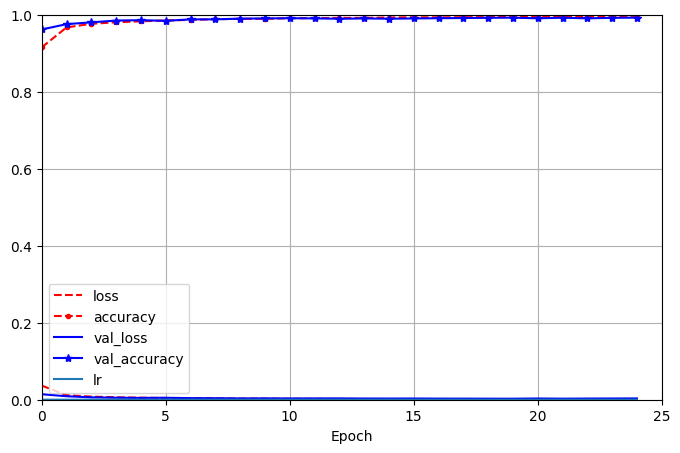

329/329 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

           N       1.00      1.00      1.00      9006
           S       0.92      0.93      0.92       297
           V       0.98      0.98      0.98       730
           F       0.88      0.80      0.84        76
           Q       1.00      0.99      1.00       394

    accuracy                           0.99     10503
   macro avg       0.96      0.94      0.95     10503
weighted avg       0.99      0.99      0.99     10503

Overall Accuracy: 99.24%
Overall F1 Score: 94.81%
Accuracy per class:
N: 99.68%
S: 92.59%
V: 98.36%
F: 80.26%
Q: 99.49%


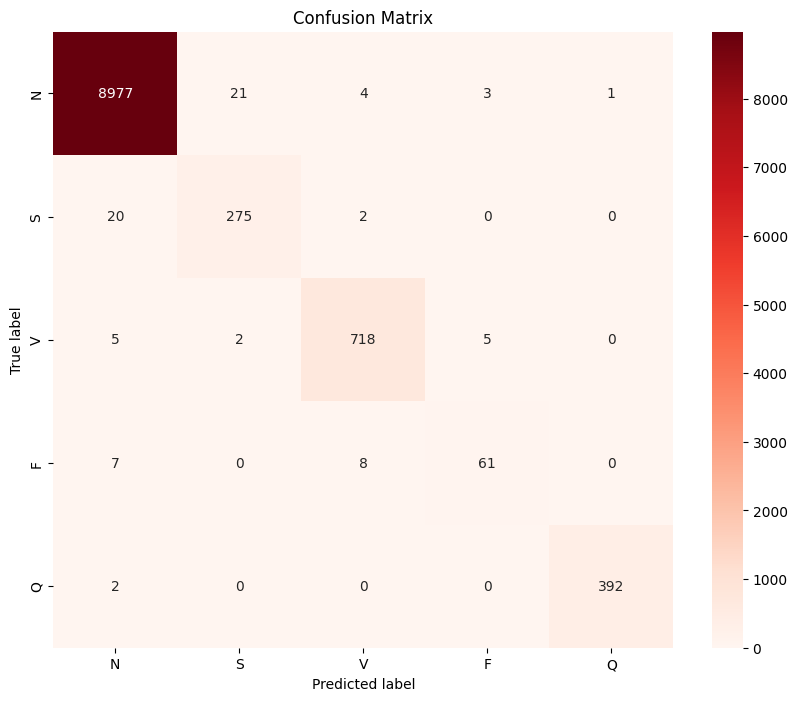

In [5]:
import tensorflow.keras as keras
from tensorflow.keras import utils
import os
import tensorflow as tf
import datetime
import numpy as np
from src import train_and_evaluate
from importlib import reload
reload(train_and_evaluate)
from src import crtnet_models
reload(crtnet_models)

def label2index(i):
    m = {'N':0, 'S':1, 'V':2, 'F':3, 'Q':4}
    return m[i]

def load_and_preprocess_data(path, num_classes):
    data = np.load(os.path.join(path, 'mitdb_data.npy'))
    label_str = np.load(os.path.join(path, 'mitdb_group.npy'))
    label = np.array([label2index(i) for i in label_str])
    one_hot = utils.to_categorical(label, num_classes=num_classes)
    return data, one_hot

path = 'data/'
num_classes = 5
class_names = ['N', 'S', 'V', 'F', 'Q']  # Update based on your classes

samples, one_hot_encoding_labels = load_and_preprocess_data(path, num_classes)

stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001)

create_crtnet_method = crtnet_models.create_crtnet_alternate_vgg1

train_and_evaluate.train_and_evaluate_model(
    create_crtnet_method,
    samples=samples,
    one_hot_encoding_labels=one_hot_encoding_labels,
    callbacks=[reduce_lr, stopping],
    is_multilabel=False,
    epochs=25,
    batch_size=128,
    classes=class_names,
    initial_learning_rate=0.0001,
    number_of_leads=1
)

